# DistilBERT Resume Experience Classifier

This notebook fine-tunes **DistilBERT** to predict **experience_level** (junior/mid/senior) from resume data.

**Approach:**
- Concatenates all resume columns into a single text sequence
- Fine-tunes `distilbert-base-uncased` for 3-class classification
- Uses HuggingFace Trainer with stratified train/test split
- Evaluates with accuracy, F1-score, and confusion matrix

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Check if running on CPU or CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "no gpu")

c:\Users\Rane\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Rane\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cuda
GPU: NVIDIA GeForce GTX 1080 Ti
True
NVIDIA GeForce GTX 1080 Ti


# Load Data

Load the cleaned resumes CSV and inspect the data distribution.


In [2]:
CSV_PATH = "cleaned_resumes.csv"
TARGET_COL = "experience_level"

df = pd.read_csv(
    "cleaned_resumes.csv",
    engine="python",
)

print("Shape:", df.shape)
print("Columns:", list(df.columns))

print("\nTarget distribution:\n", df[TARGET_COL].value_counts(dropna=False))

Shape: (2100, 15)
Columns: ['experience', 'projects', 'skills', 'summary', 'education', 'job title', 'total_experience_time', 'last_experience_time', 'summary_count', 'last_experience_only', 'experience_level', 'name', 'email', 'linkedin', 'github']

Target distribution:
 experience_level
senior    700
mid       700
junior    700
Name: count, dtype: int64


# Prepare Text Data

Concatenate all resume columns (except the target label) into a single text string per row. Each column is prefixed with its name in brackets for context.


In [3]:
def clean_value(v):
    """Convert any cell to a clean string."""
    if pd.isna(v):
        return ""
    s = str(v)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def row_to_text(row, target_col):
    parts = []
    for col, val in row.items():
        if col == target_col:
            continue
        s = clean_value(val)
        if s:
            parts.append(f"[{col}] {s}")
    return " ".join(parts)

df["text"] = df.apply(lambda r: row_to_text(r, TARGET_COL), axis=1)

print(df["text"].iloc[0][:600])
print("\nAverage text length (chars):", int(df["text"].str.len().mean()))

[experience] Experience 1: Company: Campbell-Powell. Title: qa engineer. Level: mid. Start Date: 2019-04-17. End Date: 2025-01-12. Duration: 5.74 years. Responsibilities: Perfected data analysis and data visualization using Python and Tableau. Developed and deployed scalable solutions. Integrated third-party services into existing systems. Performed software testing and resolved bugs efficiently.. Technologies: CI/CD. Methodologies: Scrum. Tools: Git, Docker, Docker. Industry: Technology. Company Size: Large. Experience 2: Company: Price Group. Title: qa engineer. Start Date: 2018-03-12. End D

Average text length (chars): 3637


# Create Label Mappings

Map the target labels (junior, mid, senior) to integer IDs for classification.


In [4]:
labels = sorted(df[TARGET_COL].dropna().unique().tolist())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

df["label"] = df[TARGET_COL].map(label2id)

print("Labels:", labels)

Labels: ['junior', 'mid', 'senior']


# Train/Test Split

Create stratified 80/20 train/test split to ensure balanced class distribution in both sets.


In [5]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (1680, 17) Test: (420, 17)


# Tokenization

Load the DistilBERT tokenizer and tokenize the train/test text data. Text is truncated/padded to max 512 tokens.


In [6]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 512
def tokenize(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN
    )

train_enc = tokenize(train_df["text"].tolist())
test_enc  = tokenize(test_df["text"].tolist())


# Create PyTorch Datasets

Wrap the tokenized data and labels into PyTorch Dataset objects for the Trainer.


In [7]:
class ResumeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = ResumeDataset(train_enc, train_df["label"].tolist())
test_dataset  = ResumeDataset(test_enc,  test_df["label"].tolist())


# Load Pre-trained Model

Load DistilBERT with a classification head for 3 classes (junior/mid/senior).


In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro")
    }


# Training Setup

Define metrics computation, training arguments, and initialize the Trainer.


In [10]:
args = TrainingArguments(
    output_dir="distilbert_resume_level",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",

    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    # weight_decay=0.01,

    logging_steps=50,
    report_to="none"
)


In [11]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # simple baseline; later you can make a validation split
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# Save fine-tuned model + tokenizer (reuse without retraining)
trainer.save_model(args.output_dir)
tokenizer.save_pretrained(args.output_dir)
print(f"Saved model + tokenizer to: {args.output_dir}")


C:\Users\Rane\AppData\Local\Temp\ipykernel_36580\1676384022.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.710500,0.686827,0.657143,0.633476
2,0.721000,0.664453,0.673810,0.660806
3,0.695000,0.681202,0.688095,0.687062


RuntimeError: [enforce fail at inline_container.cc:659] . unexpected pos 285077056 vs 285076948

In [ ]:
pred = trainer.predict(test_dataset)

y_true = test_df["label"].to_numpy()
y_pred = np.argmax(pred.predictions, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Macro-F1:", f1_score(y_true, y_pred, average="macro"))

print("\nReport:\n", classification_report(y_true, y_pred, target_names=labels))
print("\nConfusion matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.7261904761904762
Macro-F1: 0.7207578210039173

Report:
               precision    recall  f1-score   support

      junior       0.94      0.86      0.90       140
         mid       0.65      0.47      0.55       140
      senior       0.62      0.85      0.72       140

    accuracy                           0.73       420
   macro avg       0.74      0.73      0.72       420
weighted avg       0.74      0.73      0.72       420


Confusion matrix:
 [[120  14   6]
 [  8  66  66]
 [  0  21 119]]


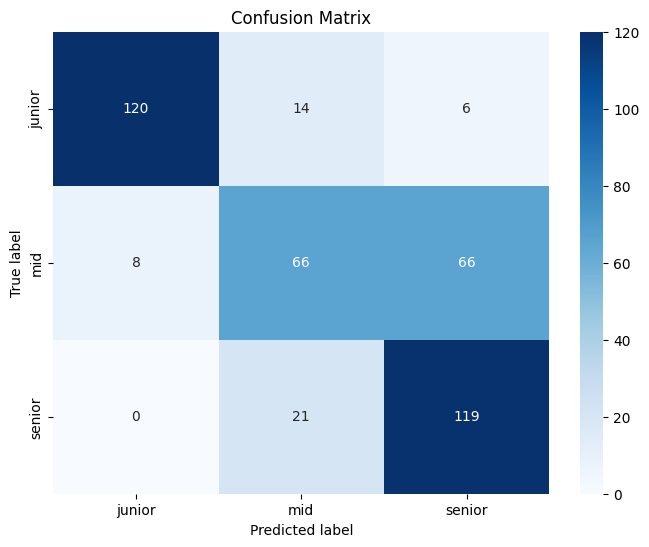

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 'y_true' and 'y_pred' are available from the previous execution
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

# Evaluation & Results

Run predictions on the test set and display accuracy, F1-score, classification report, and confusion matrix.



In [ ]:
print("Accuracy:", accuracy_score(y_true, y_pred))

Accuracy: 0.7261904761904762
